# **Lab 2:** Data Exploration and Model Training

### **Step 1:** Preparation and Authentication
Set the right parameters and authenticate your user. 

In [1]:
project_id = "jp-sandbox-359611"
location   = "us" #This is currently necessary
dataset_name = "data_journey_elt"

In [2]:
from google.cloud import bigquery
from google.cloud.bigquery import Client, QueryJobConfig

client = bigquery.Client(project=project_id)

### **Step 2:** Data Exploration
Get a feeling of the data and explore different facets and features

To remember: This is how the final training dataset looks like

| User Demographic Data | User Behavioral Data | Label 
| --- | --- | --- |
| country | cnt_user_engagement | churned
| operating_system | cnt_level_start_quickplay |  |
| language | cnt_level_end_quickplay |  |
|  |  cnt_level_complete_quickplay |  |
|  |  cnt_level_reset_quickplay |  |
|  |  cnt_post_score |  |
|  |  cnt_spend_virtual_currency |  |
|  |  cnt_ad_reward |  |
|  |  cnt_challenge_a_friend |  |
|  |  cnt_completed_5_levels |  |
|  |  cnt_use_extra_steps |  |
|  |  user_first_engagement |  | **bold text**

In [3]:
query = f"""SELECT * FROM `{dataset_name}.cc_train_dataset`"""
job = client.query(query)
df = job.to_dataframe()
df.head()

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,churned
0,654F30C1312F6C1A26DFDA9F076A62D8,United States,ANDROID,en-us,67,17,14,3,0,3,0,0,0,0,0,1530589653126001,0
1,0373DF7959F6867CDFB1C905D39CE67C,United States,ANDROID,en-us,131,4,1,1,3,31,10,0,0,1,10,1529565397802010,0
2,3EF8FC940E379D53BBD3FEFDAF626BB2,Japan,ANDROID,ja-jp,32,11,8,3,1,3,0,0,0,0,0,1528800580725002,0
3,E2D6E7FE36B7CDD0789CC8F03CC747E0,United States,ANDROID,en-us,62,7,6,1,0,6,0,0,0,1,0,1530584657063001,1
4,7D613AF4DA0F508C7090E96FD73B7E6D,United States,ANDROID,en-us,5,6,1,0,4,4,0,0,0,0,0,1530244489173004,0


<AxesSubplot:ylabel='operating_system'>

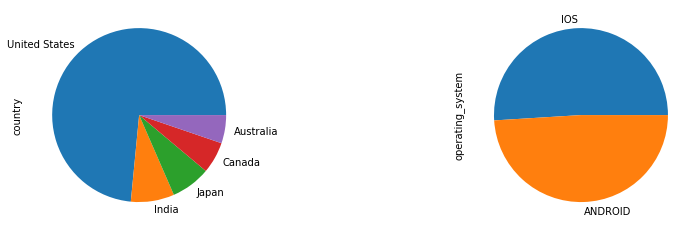

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(right=2.0)

# which country do users belong to?
df.country.value_counts(sort=True)[:5].plot(kind='pie',ax=axes[0])
# which operating system is widely used? 
df.operating_system.value_counts().plot(kind='pie', ax=axes[1])

<AxesSubplot:ylabel='churned'>

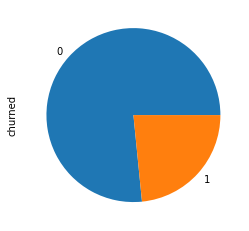

In [5]:
# How many users churned?
df.churned.value_counts().plot(kind='pie')

## **Step 3:** Train Propensity Churn Model

In [9]:
query = """
    CREATE OR REPLACE MODEL `jp-sandbox-359611.data_journey_elt.customer_churn_1_v2`
  
    OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
           INPUT_LABEL_COLS = ['churned'],
           AUTO_CLASS_WEIGHTS=TRUE,
           DATA_SPLIT_METHOD='NO_SPLIT',
           ENABLE_GLOBAL_EXPLAIN=TRUE,
           model_registry="vertex_ai",
           vertex_ai_model_id="customer_churn_1",
           vertex_ai_model_version_aliases=["test-version"])
    AS
    SELECT *
    FROM `jp-sandbox-359611.data_journey_elt.cc_train_dataset`
    
    """
client.query(query)

QueryJob<project=jp-sandbox-359611, location=US, id=ee7993f5-e99e-41f3-9b34-08e6c30467e3>

### **Feature Engineering**: How about we create new features from the **user_first_engagement** timestamp field?

Let's use the [TRANSFORM](https://cloud.google.com/bigquery-ml/docs/bigqueryml-transform) method in BigQuery ML to extract month, day of year, day of week and hour from the **user_first_enagagement** field. 

Using the TRANSFORM clause, you can specify all preprocessing during model creation. The preprocessing is **automatically** applied during the prediction and evaluation phases of machine learning 😎

In [10]:
query = """
    CREATE OR REPLACE MODEL `jp-sandbox-359611.data_journey_elt.customer_churn_2_v2`
 
    TRANSFORM(
     EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
     EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
     EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,
     EXTRACT(HOUR from TIMESTAMP_MICROS(user_first_engagement)) as hour,
     * EXCEPT(user_first_engagement, user_pseudo_id)
    )
 
    OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
           INPUT_LABEL_COLS = ['churned'],
           AUTO_CLASS_WEIGHTS=TRUE,
           DATA_SPLIT_METHOD='NO_SPLIT',
           ENABLE_GLOBAL_EXPLAIN=TRUE,
           model_registry="vertex_ai",
           vertex_ai_model_id="customer_churn_2",
           vertex_ai_model_version_aliases=["test-version"]
           )
    AS
    SELECT *
    FROM `jp-sandbox-359611.data_journey_elt.cc_train_dataset`
    
    """
client.query(query)

QueryJob<project=jp-sandbox-359611, location=US, id=b0170eeb-2c5f-4089-8880-c6954288f5c7>